🔹 Selected sample: GSM7733195


100%|██████████| 1/1 [00:00<00:00, 15.16it/s]


Raw shape: (62548, 1)
Protein expressed shape: (19243, 1)


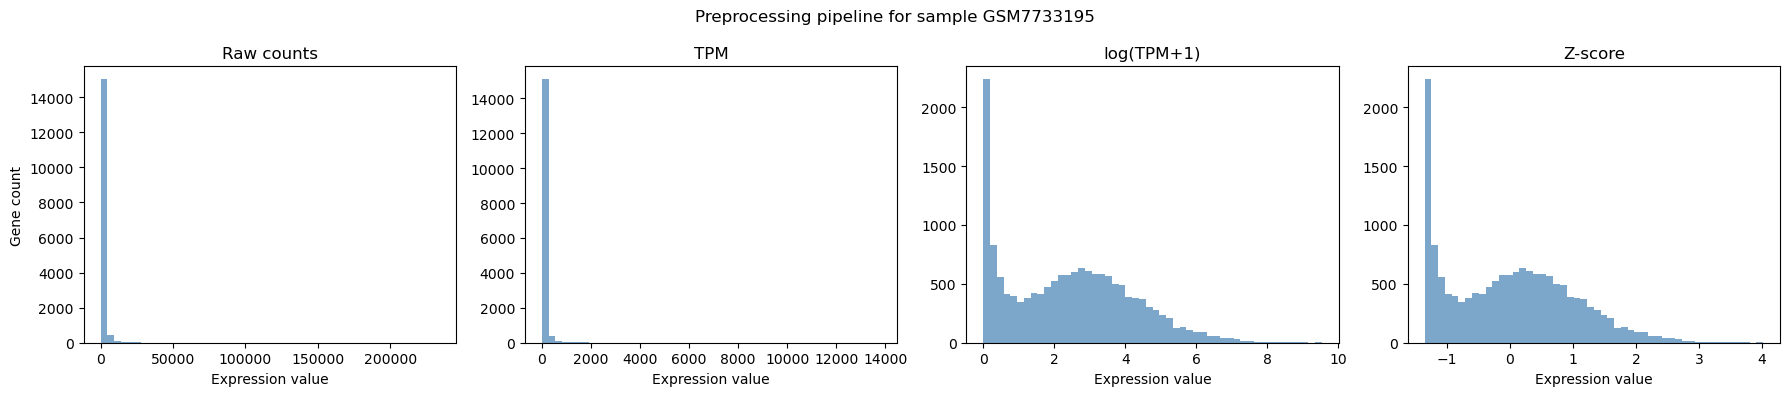


Sample gene values across stages:
G3BP1         raw=6573.0, TPM=630.2, logTPM=6.45, z=2.28
PTPN12        raw=1986.0, TPM=25.9, logTPM=3.29, z=0.50
MAP3K12       raw=731.0, TPM=8.3, logTPM=2.23, z=-0.10
SLC22A23      raw=538.0, TPM=7.9, logTPM=2.18, z=-0.13
MEIOB         raw=48.0, TPM=1.0, logTPM=0.71, z=-0.96


In [8]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from Bio import SeqIO
import archs4py as a4

# -------------------------------------------------------------
# 1️⃣ Select one random GEO sample from your train set
# -------------------------------------------------------------
meta = pd.read_csv("./data/archs4/splits/train_metadata.csv")
geo_id = np.random.choice(meta["geo_accession"])
print(f"🔹 Selected sample: {geo_id}")

# -------------------------------------------------------------
# 2️⃣ Load its raw counts
# -------------------------------------------------------------
input_h5 = "./data/archs4/human_gene_v2.5.h5"
expr = a4.data.samples(input_h5, [geo_id])
expr = expr.groupby(expr.index).sum()
print(f"Raw shape: {expr.shape}")

# -------------------------------------------------------------
# 3️⃣ Filter to protein-coding genes
# -------------------------------------------------------------
protein_fasta = "./data/ensembl/Homo_sapiens.GRCh38.pep.all.fa"
records = []
for rec in SeqIO.parse(protein_fasta, "fasta"):
    parts = {k:v for k,v in (tok.split(":",1) for tok in rec.description.split() if ":" in tok)}
    if parts.get("gene_biotype") == "protein_coding":
        records.append({"gene_symbol": parts.get("gene_symbol"), "length": len(rec.seq)})

genes_df = pd.DataFrame(records).drop_duplicates("gene_symbol")
gene_lengths = genes_df.set_index("gene_symbol")["length"]

expr = expr.loc[expr.index.intersection(gene_lengths.index)]
print(f"Protein expressed shape: {expr.shape}")

# -------------------------------------------------------------
# 4️⃣ Apply preprocessing steps sequentially
# -------------------------------------------------------------
qc_min_nonzero = 14000

# (a) Quality control
nonzero = (expr > 0).sum(axis=1)
expr_qc = expr.loc[nonzero > 0]

# (b) TPM normalization
lengths = gene_lengths.loc[expr_qc.index].fillna(1)
rate = expr_qc.div(lengths, axis=0)
expr_tpm = rate.div(rate.sum(), axis=1) * 1e6

# (c) Log transform
expr_log = np.log1p(expr_tpm)

# (d) Standardize (z-score)
expr_std = (expr_log - expr_log.mean()) / expr_log.std()

# -------------------------------------------------------------
# 5️⃣ Visualize value distributions at each step
# -------------------------------------------------------------
fig, axes = plt.subplots(1, 4, figsize=(18,4), sharey=False)
datasets = {
    "Raw counts": expr_qc,
    "TPM": expr_tpm,
    "log(TPM+1)": expr_log,
    "Z-score": expr_std
}

for ax, (title, df) in zip(axes, datasets.items()):
    ax.hist(df.values, bins=50, color="steelblue", alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel("Expression value")
axes[0].set_ylabel("Gene count")
plt.suptitle(f"Preprocessing pipeline for sample {geo_id}")
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 6️⃣ Optional: print a few example genes
# -------------------------------------------------------------
print("\nSample gene values across stages:")
genes = np.random.choice(expr_qc.index, 5)
for g in genes:
    print(f"{g:12s}  raw={expr_qc.loc[g, geo_id]:.1f}, "
          f"TPM={expr_tpm.loc[g, geo_id]:.1f}, "
          f"logTPM={expr_log.loc[g, geo_id]:.2f}, "
          f"z={expr_std.loc[g, geo_id]:.2f}")


In [1]:
"""
process_archs4_short_proteins.py
Filters ARCHS4 expression matrix to align with safe-length protein-coding genes (≤3000 aa).
"""

import os, gc, time
import numpy as np, pandas as pd
import archs4py as a4

# -------------------------------------------------------------
# CONFIGURATION
# -------------------------------------------------------------
input_h5 = "./data/archs4/human_gene_v2.5.h5"
split_csv = "./data/archs4/splits/train_metadata.csv"
ground_truth_csv = "./data/ensembl/protein_coding_genes.csv"
safe_path = "./data/ensembl/filtered/safe_sequences.csv"

batch_size = 10000
qc_min_nonzero = 14000
start = time.time()

# -------------------------------------------------------------
# 1️⃣ Load ground truth + safe subset
# -------------------------------------------------------------
genes_df = pd.read_csv(ground_truth_csv)
safe_genes = pd.read_csv(safe_path)["gene_symbol"].dropna().unique().tolist()

# Keep only safe genes
genes_df = genes_df[genes_df["gene_symbol"].isin(safe_genes)].drop_duplicates("gene_symbol")
genes_df["length"] = genes_df["seq"].str.len()
gene_lengths = genes_df.set_index("gene_symbol")["length"]
canonical_genes = genes_df["gene_symbol"].tolist()

print(f"✅ Loaded {len(genes_df):,} safe protein-coding genes (≤3000 aa)")

# -------------------------------------------------------------
# 2️⃣ Load metadata
# -------------------------------------------------------------
meta = pd.read_csv(split_csv)
geo_ids = meta["geo_accession"].tolist()
print(f"🧩 {len(geo_ids):,} train samples")

# -------------------------------------------------------------
# 3️⃣ Stream batches → normalize → accumulate
# -------------------------------------------------------------
batches = []
for i in range(0, len(geo_ids), batch_size):
    ids = geo_ids[i:i+batch_size]
    print(f"🔹 Batch {i//batch_size+1}: {len(ids)} samples")

    expr = a4.data.samples(input_h5, ids).groupby(level=0).sum()

    # Keep only safe protein-coding genes
    expr = expr.loc[expr.index.intersection(gene_lengths.index)]

    # QC
    nonzero = (expr > 0).sum(axis=0)
    expr = expr.loc[:, nonzero >= qc_min_nonzero]

    # TPM normalization
    lengths = gene_lengths.loc[expr.index].fillna(1)
    rate = expr.div(lengths, axis=0)
    expr_tpm = rate.div(rate.sum(axis=0), axis=1) * 1e6

    # Align to canonical full set and log-transform
    expr_log = np.log1p(expr_tpm.reindex(canonical_genes, fill_value=0))
    batches.append(expr_log.astype("float32"))

    del expr, expr_tpm, expr_log
    gc.collect()

# Combine all batches
expr_all = pd.concat(batches, axis=1)
print(f"✅ Combined: {expr_all.shape[0]:,} genes × {expr_all.shape[1]:,} samples")

# -------------------------------------------------------------
# 4️⃣ Align metadata
# -------------------------------------------------------------
meta = meta[meta["geo_accession"].isin(expr_all.columns)].reset_index(drop=True)
expr_all = expr_all.loc[:, meta["geo_accession"]]

# -------------------------------------------------------------
# 5️⃣ Standardize (no PCA)
# -------------------------------------------------------------
X = expr_all.T.astype(np.float32)
X_std = (X - X.mean()) / X.std()
X_std = X_std.fillna(0).to_numpy()

print(f"⏱️ Completed in {(time.time()-start)/60:.1f} min")

# -------------------------------------------------------------
# 6️⃣ Save results
# -------------------------------------------------------------
outdir = "./data/archs4/processed_short_proteins"
os.makedirs(outdir, exist_ok=True)

expr_all.to_parquet(f"{outdir}/train_expr_logtpm_short.parquet", compression="zstd")
meta.to_csv(f"{outdir}/train_metadata_short.csv", index=False)
np.save(f"{outdir}/train_X_std_short.npy", X_std)
pd.Series(expr_all.index, name="gene_symbol").to_csv(
    f"{outdir}/train_gene_order_short.csv", index=False
)

print("\n✅ Saved short-protein–aligned data:")
print(f"  - Expression matrix: {outdir}/train_expr_logtpm_short.parquet")
print(f"  - Metadata:          {outdir}/train_metadata_short.csv")
print(f"  - Standardized data: {outdir}/train_X_std_short.npy")
print(f"  - Gene order:        {outdir}/train_gene_order_short.csv")


✅ Loaded 19,357 safe protein-coding genes (≤3000 aa)
🧩 102,912 train samples
🔹 Batch 1: 10000 samples


100%|██████████| 10000/10000 [01:16<00:00, 130.13it/s]


🔹 Batch 2: 10000 samples


100%|██████████| 10000/10000 [01:14<00:00, 133.43it/s]


🔹 Batch 3: 10000 samples


100%|██████████| 10000/10000 [01:13<00:00, 135.95it/s]


🔹 Batch 4: 10000 samples


100%|██████████| 10000/10000 [01:13<00:00, 135.89it/s]


🔹 Batch 5: 10000 samples


100%|██████████| 10000/10000 [01:14<00:00, 134.52it/s]


🔹 Batch 6: 10000 samples


100%|██████████| 10000/10000 [01:13<00:00, 135.20it/s]


🔹 Batch 7: 10000 samples


100%|██████████| 10000/10000 [01:16<00:00, 130.29it/s]


🔹 Batch 8: 10000 samples


100%|██████████| 10000/10000 [01:13<00:00, 136.66it/s]


🔹 Batch 9: 10000 samples


100%|██████████| 10000/10000 [01:14<00:00, 133.92it/s]


🔹 Batch 10: 10000 samples


100%|██████████| 10000/10000 [01:13<00:00, 135.48it/s]


🔹 Batch 11: 2912 samples


100%|██████████| 2912/2912 [00:22<00:00, 132.05it/s]


✅ Combined: 19,357 genes × 76,286 samples
⏱️ Completed in 25.9 min

✅ Saved short-protein–aligned data:
  - Expression matrix: ./data/archs4/processed_short_proteins/train_expr_logtpm_short.parquet
  - Metadata:          ./data/archs4/processed_short_proteins/train_metadata_short.csv
  - Standardized data: ./data/archs4/processed_short_proteins/train_X_std_short.npy
  - Gene order:        ./data/archs4/processed_short_proteins/train_gene_order_short.csv


In [ ]:
outdir = "./data/archs4/processed_short_proteins"
os.makedirs(outdir, exist_ok=True)

# Save processed matrices
expr_all.to_parquet(f"{outdir}/train_expr_logtpm_short.parquet", compression="zstd")
meta.to_csv(f"{outdir}/train_metadata_short.csv", index=False)

# Save standardized numpy array and gene order
np.save(f"{outdir}/train_X_std_short.npy", X_std)
pd.Series(expr_all.index, name="gene_symbol").to_csv(
    f"{outdir}/train_gene_order_short.csv", index=False
)

print("✅ Saved short-protein–aligned training data:")
print(f"  - Expression matrix: {outdir}/train_expr_logtpm_short.parquet")
print(f"  - Metadata:          {outdir}/train_metadata_short.csv")
print(f"  - Standardized data: {outdir}/train_X_std_short.npy")
print(f"  - Gene order:        {outdir}/train_gene_order_short.csv")


✅ Saved:
  - Expression matrix: ./data/archs4/processed/train_expr_logtpm.parquet
  - Metadata:          ./data/archs4/processed/train_metadata_final.csv
  - Standardized data: ./data/archs4/processed/train_X_std.npy
  - Gene order:        ./data/archs4/processed/train_gene_order.csv


In [3]:
import pandas as pd

gene_order_path = "./data/archs4/processed/gene_order.csv"
gene_order = pd.read_csv(gene_order_path)

# Basic integrity checks
print("🧪 Checking gene_order.csv...")
print("Total entries:", len(gene_order))

# Check for nulls or empty strings
null_count = gene_order.isnull().sum().values[0]
empty_count = (gene_order["gene_symbol"].astype(str).str.strip() == "").sum()

print(f"Null values:  {null_count}")
print(f"Empty strings: {empty_count}")

if null_count == 0 and empty_count == 0:
    print("✅ gene_order.csv is clean — no missing or empty gene symbols.")
else:
    print("⚠️ Warning: missing or blank entries found — check FASTA parsing and reindexing.")


🧪 Checking gene_order.csv...
Total entries: 19477
Null values:  0
Empty strings: 0
✅ gene_order.csv is clean — no missing or empty gene symbols.


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt, seaborn as sns

start = time.time()

# -------------------------------------------------------------
# 6️⃣ Run t-SNE directly
# -------------------------------------------------------------
print("⚙️ Running t-SNE...")
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1000,
    init="random",
    random_state=42,
    verbose=1
)
X_emb = tsne.fit_transform(X_std)

# -------------------------------------------------------------
# 7️⃣ Plot
# -------------------------------------------------------------
plt.figure(figsize=(8,6))
palette = dict(zip(sorted(meta["tcga_label"].unique()),
                   sns.color_palette("tab20", len(meta["tcga_label"].unique()))))

for label, color in palette.items():
    idx = meta["tcga_label"] == label
    plt.scatter(X_emb[idx,0], X_emb[idx,1], s=15, alpha=0.7, color=color, label=label)

plt.title("t-SNE — ARCHS4 Train Set (PreBULK, no PCA)")
plt.xlabel("t-SNE-1"); plt.ylabel("t-SNE-2")
plt.legend(markerscale=1.2, fontsize=7, bbox_to_anchor=(1.05,1))
plt.tight_layout(); plt.show()

print(f"⏱️ Completed in {(time.time()-start)/60:.1f} min")